# CLIP

In this exercise, you'll learn how you can use pretrained vision-language models for transfer learning as well as zero-shot classification and retrieval.

You'll need to install the python packages `open_clip_torch` and `tqdm`, e.g. with `pip install open_clip_torch tqdm`.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import open_clip
import torch
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from tqdm import tqdm

## Dataset

For this exercise, we're going to use a small dataset with about 500 images which are sorted into 6 different categories. You can download the dataset from https://nc.mlcloud.uni-tuebingen.de/index.php/s/KmPbJaZ7gB7Fbp9 (about 130MB) and unzip it in the current directory. This should give you a new sub directory `image_dataset`. Now we load the data, split it into a training and a validation part and look at a few examples from the validation set.

In [8]:
dataset = ImageFolder('image_dataset', transform=ToTensor())

generator = torch.Generator().manual_seed(42)
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 100, 100], generator=generator)

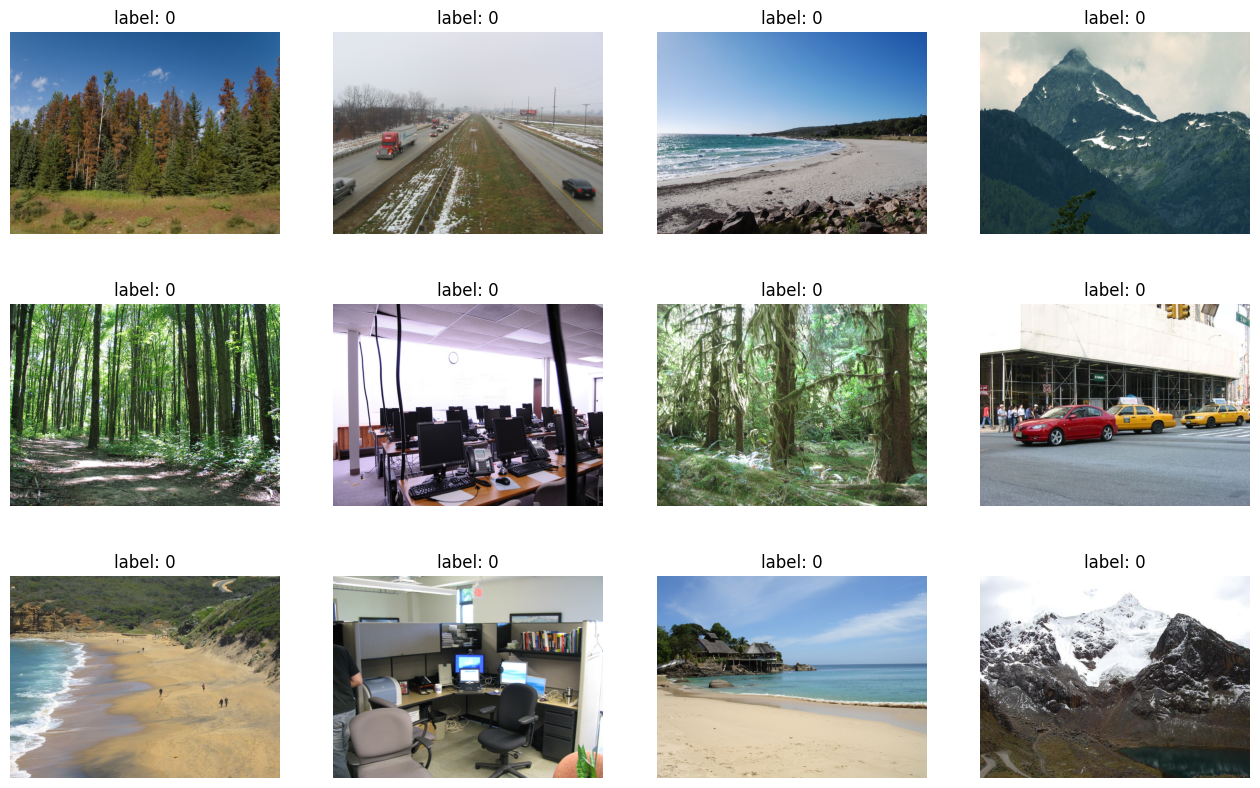

In [9]:
rst = np.random.RandomState(43)
f, axes = plt.subplots(3, 4, figsize=(16, 10))

for ax in axes.flatten():
    image, label = validation_dataset[rst.randint(len(validation_dataset))]
    ax.imshow(image.numpy().transpose(1, 2, 0))
    ax.set_title(f"label: {label}")
    ax.set_axis_off()

Label 0: 0
Label 1: 0
Label 2: 0
Label 3: 0
Label 4: 0


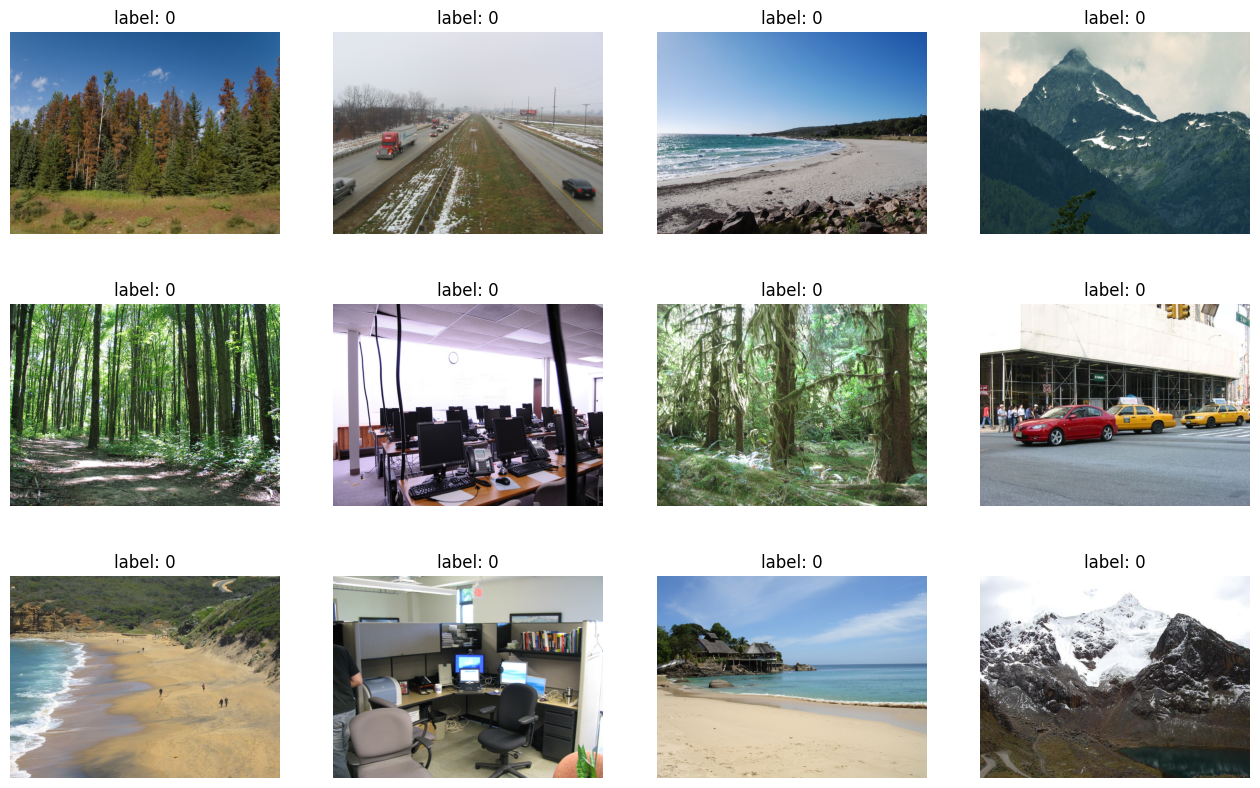

In [6]:
rst = np.random.RandomState(43)
f, axes = plt.subplots(3, 4, figsize=(16, 10))

for ax in axes.flatten():
    image, label = validation_dataset[rst.randint(len(validation_dataset))]
    ax.imshow(image.numpy().transpose(1, 2, 0))
    ax.set_title(f"label: {label.item() if hasattr(label, 'item') else label}")
    ax.set_axis_off()

# Überprüfen Sie die ersten paar Labels im Dataset
for i in range(5):
    _, label = validation_dataset[i]
    print(f"Label {i}: {label.item() if hasattr(label, 'item') else label}")

## Linear Classification

First, we want to try to classify the images with a simple linear classifier, which we implement in pytorch and train using crossentropy.

In [15]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    
)

val_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

In [ ]:
class LinearClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # we first downsample by a factor of 10 to make things a bit simpler
        self.pool1 = torch.nn.AvgPool2d((10, 10))
        self.linear1 = torch.nn.Linear(60 * 80 * 3, 6)
    
    def forward(self, x):
        x = self.pool1(x)
        x = x.view(-1, 60 * 80 * 3)
        x = self.linear1(x)
        return x
    
model = LinearClassifier()

We train the classifier for crossentropy. We additionally employ a learning rate decay schedule: After certain numbers of epochs, the learning rate will be decayed by a factor of 10. You have to decide about optimizer, initial learning rate and decay schedule

In [ ]:
# specify loss function
criterion = torch.nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.TODO(model.parameters(), other_arguments)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000, 2000])  # choose two decay milestones

In [ ]:
# number of epochs to train the model
n_epochs = TODO

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        #print(data.shape)
        #print(target.shape)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()*data.size(0)
    lr_scheduler.step()
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval() # prep model for *evaluation*

for data, target in val_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(val_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

#### Exercise 3.1

Try to find good choices for optimizer, initial learning rate and decay schedule. Does the linear classifier reach a good performance on the validation set? If not, what kind of reasons might be responsible for this?

*put your answer here*

### Linear Classifier on CLIP embedding

In this section, we'll employ transfer learning: Instead of learning a model from scratch, we'll put a linear readout on top of a pretrained CLIP vision encoder. We'll keep the CLIP model fixed and only train the linear readout.

In [ ]:
# download and load the CLIP model. Depending on your internet connection, the download will take some time, but it need to be done only once.
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
clip_model.eval()

# the tokenizer is a preprocessing for the text encoder that we'll need later.
tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [ ]:
# for the CLIP model, we need a different preprocessing, which conveniently has been provided by `create_model_and_transforms`.
# This preprocessing transforms and crops the image to the required size for the model
# Because of this, we need to build dataset and data loaders again.

dataset = ImageFolder('image_dataset', transform=preprocess)
generator = torch.Generator().manual_seed(42)  # set seed to make split deterministic
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 100, 100], generator=generator)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    
)

val_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

In [ ]:
class CLIPClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = clip_model
        # freeze the CLIP parameters
        for parameter in self.backbone.parameters():
            parameter.requires_grad = False
        self.readout = torch.nn.Linear(512, 6)
    
    def forward(self, x):
        # we don't want to train the CLIP model
        with torch.no_grad():
            embedding = self.backbone.encode_image(x)
        
        logits = self.readout(embedding)
        return logits
    
    def train(self, mode=True):
        super().train(mode=mode)
        # keep backbone in evalm mode
        self.backbone.eval()
    
model = CLIPClassifier()

In [ ]:
# specify loss function
criterion = torch.nn.CrossEntropyLoss()

# specify optimizer

optimizer = torch.optim.TODO(model.parameters(), ...)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000,2000,3000]) # adapt

In [ ]:
# number of epochs to train the model
n_epochs = 1000000  # adapt

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        #print(data.shape)
        #print(target.shape)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        #print(data)
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()*data.size(0)
    lr_scheduler.step()
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval() # prep model for *evaluation*

for data, target in val_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(val_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

#### Exercise 3.2

Select optimizer, initial learning rate and decay schedule to train the linear readout on top of the CLIP model. What kind of performance do you get? Is the result in some sense surprising? How is performance on validation and training set related to the results of the linear classifier trained in 3.1? How do you explain the differences? What kind of differences did you notice in the training dynamcis compared to the purely linear model above?

*put your answers here*

## CLIP with zero shot text based classification

One of the special properties of CLIP models is that they are not just image models, but a vision language model. This facilitates zero shot classification using text queries. This example demonstrates how you can compute scores (logits) for different text queries given an image

In [ ]:
text = tokenizer(["a diagram", "a dog", "a cat"])
image = train_dataset[0][0].unsqueeze(0)

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = clip_model.encode_image(image)
    text_features = clip_model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_logits = (100.0 * image_features @ text_features.T)
    text_probabilities = text_logits.softmax(dim=-1)
    print(text_probabilities)

Use this example to construct a text based classifier. The `text_logits` from the example are essentially what used to be the model output previously. Since we're now in a *zero-shot setting*, there is no training involved and we only need to the evaluation loop.

In [ ]:
# these are the text queries that characterize the different classes in the dataset. You'll need to find good queries yourself.
queries = [
    'query for class label 0',
    'query for class label 1',
    'query for class label 2',
    'query for class label 3',
    'query for class label 4',
    'query for class label 5',
]

text = tokenizer(queries)
text_features = clip_model.encode_text(text)
text_features /= text_features.norm(dim=-1, keepdim=True)

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval() # prep model for *evaluation*

for data, target in val_loader:
    # TODO: compute text_logits as in the example in the previous cell
    # note that the text features are already computed because they
    # don't change from image to image
    text_logits = ...
    
    # calculate the loss
    loss = criterion(text_logits, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(val_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
        

#### Exercise 3.3

Complete the above snippet for the text-based classifier and make it work. Try to find good text queries for the six different classes. What kind of performance do you get? How did you find the queries? What are advantages and disadvantages compared to the linear classifier?

*put your answers here*

### Text based Image Retrieval

Image retrieval is the task of finding the best matching image given a certain query that here will be formulated as text. Because no training is needed anymore, we'll now use the full dataset

In [ ]:
raw_dataset = ImageFolder('image_dataset')  # we'll need this later to display the original images
dataset = ImageFolder('image_dataset', transform=preprocess)

To do so, we first need to build a database of CLIP embeddings for all candidate images.

In [ ]:
# We compute normalized images features for each image in the training dataset
# and concatenate them into a (N_images, N_features) dimensional torch tensor that then can be used for fast image querying.
embeddings = []
labels = []

for image, label in tqdm(dataset):
    image_tensor = image.unsqueeze(0)
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = clip_model.encode_image(image_tensor)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    # save image features
    embeddings.append(image_features)
    labels.append(label)

# build "embedding database"
embeddings = torch.concat(embeddings)

This is the image that we want to find in the dataset:

In [ ]:
plt.imshow(raw_dataset[100][0])
plt.axis('off');

To find images matching a text query, instead of matching one image against multiple texts, we'll now match many images against one text. By sorting the images according to the returned CLIP scores, we can display the most promising matches.

In [ ]:
query = 'some image description'  # fill in

text = tokenizer(query)

# compute probabilities for each image given the text query
# this is very similar to the snippets above, but be
# careful: now we're not interested in probabilites for each text query
# but in probabilities for each image. Hence there will be subtle changes
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = TODO
    image_logits = TODO
    image_probabilities = TODO
    
sorted_indices = np.argsort(image_probabilities.numpy())
sorted_indices = sorted_indices[::-1]
    
f, axes = plt.subplots(1, 5, figsize=(16, 4))
for index, ax in zip(sorted_indices, axes):
    #print(index)
    image = raw_dataset[index][0]
    ax.imshow(image)
    ax.set_axis_off()
    ax.set_title(f"probability: {image_probabilities[index].numpy():.0%}")


#### Excercise 3.4

Complete the code above and find a text query that returns the target image as best matching candidate. How well can you separate it from other images? With other words, how high can you drive the assigned probability for the correct image? Descrie how you found the query that you used in the end.

*put your answers here*